# Data re-uploading for a universal quantum classifier

将经典数据重复的加载到量子线路中来提高训练的效率

In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)

In [29]:
def plot_data(x,y):
    fig,ax=plt.subplots(1,1,figsize=(5,5))
    reds=y==0
    blues=y==1
    ax.scatter(x[reds,0],x[reds,1],c='red',s=20,edgecolors='k')
    ax.scatter(x[blues,0],x[blues,1],c="blue",s=20,edgecolors='k')
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

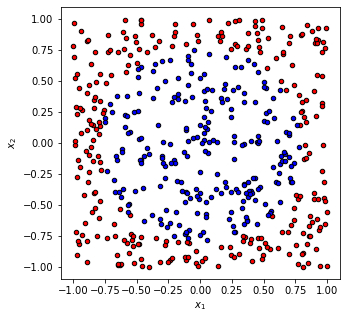

In [30]:
def circle(samples, center=[0.0,0.0],radius=np.sqrt(2/np.pi)):
    xval,yval=[],[]
    for i in range(samples):
        x=2*(np.random.rand(2))-1
        y=0
        if np.linalg.norm(x-center)<radius:
            y=1
        xval.append(x)
        yval.append(y)
    return np.array(xval), np.array(yval)
Xdata, ydata = circle(500)
plot_data(Xdata,ydata)

In [31]:
num_layers = 3
learning_rate = 0.01
epochs = 10
batch_size = 32

In [37]:
num_training = 200
num_test = 2000

Xdata, y_train = circle(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1))))
X_train = np.hstack((X_train, y_train[:, None]*np.pi))
Xtest, y_test = circle(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1))))
X_test = np.hstack((X_test, y_test[:, None]*np.pi))

In [6]:
from mindquantum import *

In [126]:
template = Circuit().rz('0',0).ry('1',0).rz('2',0).h(0)
encoder = add_prefix(template, 'e')
ansatz = add_prefix(template, 'a')
circuit = sum([encoder + add_prefix(ansatz, f"{i}") for i in range(num_layers)])
circuit += RX('e_3').on(0)
encoder_params = encoder.params_name + ['e_3']
ansatz_params = circuit.params_name[3:-1]
circuit.svg()

In [127]:
ham = Hamiltonian(QubitOperator(''))

In [128]:
import mindspore as ms
ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")

In [129]:
sim = Simulator('projectq', 1)
grad_ops = sim.get_expectation_with_grad(ham, circuit, circ_left=Circuit(), encoder_params_name=encoder_params,ansatz_params_name=ansatz_params)

In [130]:
import mindspore.dataset as ds
from mindspore import Model
from mindspore.train.callback import LossMonitor

In [131]:
train_set = ds.NumpySlicesDataset({
    "data":X_train,"label":y_train
},shuffle=True).batch(batch_size)
test_set = ds.NumpySlicesDataset({
    "data":X_test,"label":y_test
},shuffle=True).batch(num_test)

In [132]:
class Hybird(ms.nn.Cell):
    def __init__(self, qnet):
        super(Hybird, self).__init__()
        self.qnet = qnet
        self.mean = ms.ops.ReduceMean()
    def construct(self, x):
        x = self.qnet(x)
        return -self.mean(x)

In [139]:
qnet = MQN2Layer(grad_ops)
net = Hybird(qnet)
opti = ms.nn.Adam(net.trainable_params(), learning_rate=0.01)
train_net = ms.nn.TrainOneStepCell(net, opti)

In [140]:
for epoch in range(20):
    for i,j in train_set:
        loss = train_net(i)
    print(loss)

-0.5219083
-0.4704969
-0.36478135
-0.62562543
-0.5686002
-0.67925817
-0.7822181
-0.68642336
-0.64360476
-0.5849463
-0.5412219
-0.75936496
-0.7149602
-0.73002684
-0.6668851
-0.6872451
-0.6711199
-0.65922576
-0.666737
-0.6197759


In [141]:
pr_ansatz = dict(zip(ansatz_params, qnet.weight.asnumpy()))
predict_circ = circuit[:-1]
sim =Simulator('projectq', 1)
h = Hamiltonian(QubitOperator('Z0'))
predict = []
for i in X_test:
    sim.reset()
    i=i[:-1]
    pr = dict(zip(encoder_params[:-1], i))
    pr.update(pr_ansatz)
    sim.apply_circuit(predict_circ, pr=pr)
    predict.append(sim.get_expectation(h))
predict = np.array(predict)

In [142]:
print(f'accuracy: {np.mean((predict<0).astype(int)==y_test)}')

accuracy: 0.8635


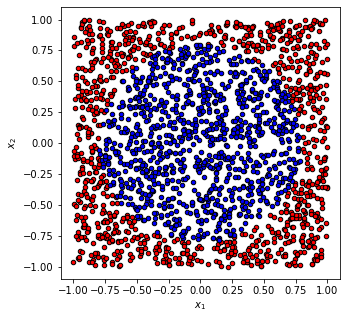

In [143]:
plot_data(X_test,y_test)

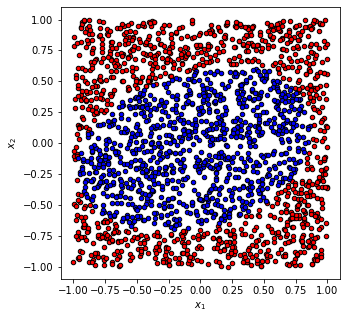

In [144]:
plot_data(X_test, (predict<0).astype(int))